# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [1]:
# Install all the required packages for building model using CRF

!pip install -U ‘scikit-learn<0.24’ # To not receive any error while fitting the model

!pip install pycrf
!pip install sklearn-crfsuite

zsh:1: no such file or directory: 0.24’


In [2]:
# Import all the libraries required for proceeding in model creation, training, Evaluation
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

# To match and find tokens based on dependency or Pos tag etc...
from spacy.matcher import Matcher

import pandas as pd
import numpy as np

In [3]:
# Load the spacy mdoel required for our problem statement.

# Here we are using the model 'en_core_web_sm' 
# (i.e Model that got trained using data from web sites in english language and 
# can perform core operations like pos tagging, entities finding etc... )

model = spacy.load("en_core_web_sm")

### Load Data

###### Load the train and test data sntences including with their lables for further proceeding in the assignment

In [4]:
# Load the data using pandas library

# Create a connections to open files for reading and loading
train_sent_con = open("train_sent",'r', encoding="utf-8")
train_label_con = open("train_label",'r', encoding="utf-8")

test_sent_con = open("test_sent",'r', encoding="utf-8")
test_label_con = open("test_label",'r', encoding="utf-8")

# Load Training Sentenes data and labels data
train_sent_raw_data = train_sent_con.read()
train_label_raw_data = train_label_con.read()

# Load Testing sentences data and labels data
test_sent_raw_data = test_sent_con.read()
test_label_raw_data = test_label_con.read()


# Close the connections ones loaded data completely
train_sent_con.close()
train_label_con.close()

test_sent_con.close()
test_label_con.close()

In [5]:
# Makes a list of data for training and testing 

train_sent_data = train_sent_raw_data.split("\n")
train_label_data = train_label_raw_data.split("\n")

test_sent_data = test_sent_raw_data.split("\n")
test_label_data = test_label_raw_data.split("\n")

In [6]:
# Print some data of training sentences, labels and testing sentences, labels
print("Raw Training sentences and labels")
print(train_sent_data[0:10])
print(train_label_data[0:10])
print("\n")
print("Raw Testing sentences and labels")
print(test_sent_data[0:10])
print(test_label_data[0:10])

Raw Training sentences and labels
['All', 'live', 'births', '>', 'or', '=', '23', 'weeks', 'at', 'the']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


Raw Testing sentences and labels
['Furthermore', ',', 'when', 'all', 'deliveries', 'were', 'analyzed', ',', 'regardless', 'of']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


### Construct the proper sentences from individual words and print the 5 sentences.

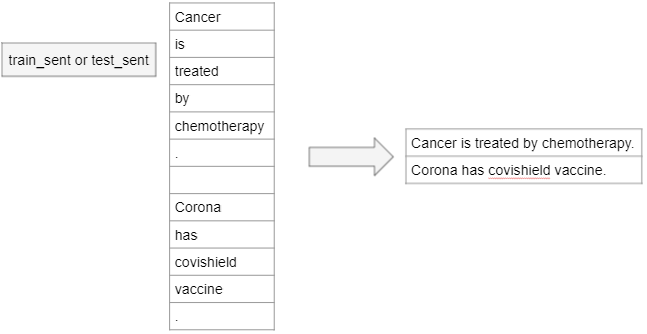

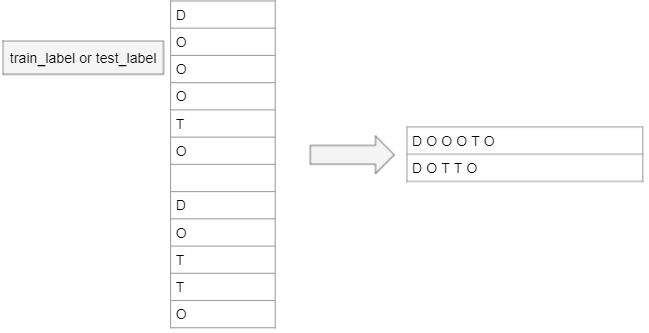

In [7]:
# Generate sentence from raw data of words or labels
def generateProperSentences(raw_data):
    # Empty lists to hold all sentences and a single sentence
    wholeSentences = [];
    singleSentence = [];
    
    # Iterate to each and every word from raw_data list
    for data in raw_data:
        if data == " " or len(data) == 0: # Create a sentence and add it to whole sentences if we find a Space.
            sentence = " ".join(singleSentence); # Generate a sentence from List
            if len(sentence) != 0:
                wholeSentences.append(sentence); # Append it to whole sentences
            singleSentence = []; # Initialize the list of singleSentence for holding next sentence data
        else:
            singleSentence.append(data); # Add data of label or words for a single sentence
    
    return wholeSentences; # return all sentences of words or labels

# Method to generate proper sentences, lables from the given raw word and labels list
def generateProperSentencesNdLabels(raw_words, raw_labels):
    sentences = generateProperSentences(raw_words); # generate proper sentences of words
    sentenceLables = generateProperSentences(raw_labels); # generate proper sentence of labels
    
    return sentences, sentenceLables # return all sentences and labels

# Preprocess the whole training, testing sentences and labels data
def preProcessTheData(raw_train_words, raw_train_labels, raw_test_words, raw_test_labels):
    
    # Generate proper sentence of words and labels for training data
    properTrainSentences, properTrainSentenceLables = generateProperSentencesNdLabels(raw_train_words, raw_train_labels);

    # Generate proper sentence of words and labels for Testing data    
    properTestSentences, properTestSentenceLables = generateProperSentencesNdLabels(raw_test_words, raw_test_labels);
    
    # return whole proper sentences of training, testing sentences of words and lables
    return properTrainSentences, properTrainSentenceLables, properTestSentences, properTestSentenceLables;



In [8]:
# Preprocess Training and Testing sentences, labels data
properTrainSentences, properTrainSentenceLables, properTestSentences, properTestSentenceLables = preProcessTheData(train_sent_data, train_label_data, test_sent_data, test_label_data)

# Training sentences and labels
train_sent = properTrainSentences;
train_label = properTrainSentenceLables;

# Testing sentences and labels
test_sent = properTestSentences;
test_label = properTestSentenceLables;


In [9]:
# Whole data of training and testing for sentences, labels
data_sent = [];
data_sent.extend(train_sent);
data_sent.extend(test_sent);

data_label = [];
data_label.extend(train_label);
data_label.extend(test_label);


In [10]:
print("Printing Whole data first and last five sentences");
print("-----------------------------------------------------------------");
print("\n\n".join(data_sent[0:5]), "\n\n".join(data_sent[-5:]))

print("\n")

print("Printing Whole data first and last five labels");
print("-----------------------------------------------------------------");
print("\n".join(data_label[0:5]), "\n".join(data_label[-5:]))


Printing Whole data first and last five sentences
-----------------------------------------------------------------
All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )

Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )

The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )

Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively ) Reduction of vasoreactivity and thrombogenicity with laser-thermal angioplasty : comparison with balloon angioplasty

Effects of ultrasound energy on total peripher

### Count the number of sentences in the processed train and test dataset 

In [11]:
print("Total Sentences in Train : ", len(train_sent))
print("Total Sentences in Test : ", len(test_sent))

Total Sentences in Train :  2599
Total Sentences in Test :  1056


### Count the number of lines of labels in the processed train and test dataset.

In [12]:
print("Total Labels in Train : ", len(train_label))
print("Total Labels in Test : ", len(test_label))

Total Labels in Train :  2599
Total Labels in Test :  1056


### Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [13]:
# required pos tags
req_pos_tags = ["NOUN", "PROPN"]

In [14]:
# Method to check if Pos tags is having the required pos tags data or not
def isNounOrPropon(posTags):
    return (posTags in req_pos_tags);

# Method to return the sentence processed by model(NLP)
def getProcessedSent(sentence):
    processed_sent = model(sentence);
    return processed_sent;

# Method to return a dictionary of token with its frequencey which is having required POS tags
def getTokenNdFreqDict(totalSentData):
    tokenNdFreqDict = dict(); # Initialize the dictionary to store the token and its frequency
    for sent in totalSentData: # Process each and every sentence of dataset 
        processed_raw_sent = getProcessedSent(sent); # Get processed sentence from model(nlp)
        for processed_sent in processed_raw_sent: # process data of each token of processed data by model(nlp) 
            if isNounOrPropon(processed_sent.pos_): # Check if the token POS tag is in the required pos tags list
                rawToken = processed_sent.text; # Get the token text data
                token = rawToken.lower(); # make the token to lower case so that same token with different cases are gets counted without missing
                freq = tokenNdFreqDict.get(token, 0); # Check if token is already in dict. If not return its freq as 0.
                tokenNdFreqDict[token] = freq + 1; # Increment the existing token freq and update in dictionary
            
    return tokenNdFreqDict; # Return the token and freq dictionary


In [15]:
data_sent


['All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )',
 'The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )',
 'Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )',
 "The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )",
 "Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )",
 'Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age',
 'In the third trimester , the amniotic fluid index ( AFI ) may be affected by maternal fluid 

In [16]:
tokensNdFreqDict = getTokenNdFreqDict(data_sent);

print(len(tokensNdFreqDict))

5751


In [17]:
tokensNdFreqDict

{'births': 2,
 '=': 16,
 'weeks': 37,
 'university': 7,
 'vermont': 1,
 'delivery': 22,
 'route': 2,
 'indication': 5,
 'cesarean': 4,
 'age': 56,
 'parity': 4,
 'practice': 32,
 'group': 111,
 'risk': 74,
 'status': 17,
 'rate': 68,
 '%': 247,
 'presentation': 7,
 'medicine': 42,
 'patients': 507,
 'arrest': 6,
 'dilation': 4,
 'subgroups': 4,
 'rates': 35,
 'care': 57,
 'hospitals': 10,
 'community': 16,
 'groups': 34,
 'trimester': 4,
 'index': 14,
 'afi': 7,
 'fluid': 6,
 'temperature': 10,
 'increases': 7,
 'decrease': 6,
 'june': 2,
 'august': 6,
 'period': 28,
 'heat': 5,
 'women': 81,
 'singleton': 1,
 'pregnancies': 7,
 'gestation': 4,
 'antenatal': 5,
 'testing': 25,
 'determinations': 2,
 'area': 13,
 '2-': 3,
 'day': 36,
 'test': 22,
 'date': 3,
 'spearman': 1,
 'rank': 2,
 'correlation': 19,
 'relationship': 14,
 'account': 4,
 'measure': 4,
 'study': 174,
 'population': 31,
 'diabetes': 34,
 'screening': 14,
 'clinic': 6,
 'hadassah': 1,
 'medical': 6,
 'center': 10,
 'ye

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [18]:
from collections import Counter

counter = Counter(tokensNdFreqDict); # Initialize the counter object with the required dictionary
top_25 = counter.most_common(25) # Get the top 25 dictionary data based on the value of the dictionary

for top in top_25: # Iterate and print each key and value from dictionary
    print(top[0], ":", top[1])


patients : 507
treatment : 304
% : 247
cancer : 211
therapy : 177
study : 174
disease : 150
cell : 142
lung : 118
results : 117
group : 111
effects : 99
gene : 91
chemotherapy : 91
use : 88
effect : 82
women : 81
analysis : 76
to_see : 75
risk : 74
surgery : 73
cases : 72
p : 72
rate : 68
dose : 68


## Defining features for CRF





In [19]:
# Let's define the features to get the feature value for one word.
def getFeaturesForSingleWord(sentence, posTags, pos):
    
    word = sentence[pos]
    
    features = [
        'word.lower=' + word.lower(), # serves as word id
        'word[-3:]=' + word[-3:],     # last three characters
        'word[-2:]=' + word[-2:],     # last two characters
        'word.isupper=%s' % word.isupper(),  # is the word in all uppercase
        'word.isdigit=%s' % word.isdigit(),  # is the word a number
        'word.startsWithCapital=%s' % word[0].isupper(), # is the word starting with a capital letter
        'word.pos=' + posTags[pos]
      ]
    
    if pos > 0:
        prev_word = sentence[pos-1];
        features.extend([
            'prev_word.lower=' + prev_word.lower(), 
            'prev_word.isupper=%s' % prev_word.isupper(),
            'prev_word.isdigit=%s' % prev_word.isdigit(),
            'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
            'prev_word.pos=' + posTags[pos-1]
          ])
    else:
        features.append('BEG')
    
    if pos == len(sentence)-1:
        features.append('END')
        
    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [20]:
# Method to return the posTags for a given sentence
def getPosTags(sentence):
    posTags = [];
    processed_sent = model(sentence); # Process the sentence using model(nlp)
    for token in processed_sent: # Iterate to processed data and get Pos tag and add to list
        posTags.append(token.pos_);
    return posTags;

# Generate features for each sentence
def getFeaturesForSingleSentence(sentence):
    sentenceFeatures = [];
    posTags = getPosTags(sentence);
    sentenceAsList = sentence.split(); # Get sentence as list for processing the words in sentence easily 
    sentenceFeatures = [getFeaturesForSingleWord(sentenceAsList, posTags, pos) for pos in range(0, len(sentenceAsList))];
    return sentenceFeatures;

# Process whole data set for features
def getFeaturesForDataSet(dataSet):
    features = [];
    features = [getFeaturesForSingleSentence(sentence) for sentence in dataSet];
    return features;


### Write a code/function to get the labels of a sentence

In [21]:
# Makes lables data as list
def getLablesAsList(labels):
    labelsAsList = labels.split();
    return labelsAsList;

# Get lables data for whole data set
def getLablesAsListForDataSet(dataSet):
    labelsData = []
    labelsData = [getLablesAsList(labels) for labels in dataSet]
    return labelsData;

## Define input and target variables


Correctly computing X and Y sequence matrices for training and test data.
Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [22]:
# Generate features for training sentences
X_train = getFeaturesForDataSet(train_sent)

# Generate features for testing sentences
X_test = getFeaturesForDataSet(test_sent)

### Define the labels as the target variable for test and the train dataset

In [23]:
# Generate lables corresponds to sentence data for training data
Y_train = getLablesAsListForDataSet(train_label)

# Generate lables corresponds to sentence data for testing data
Y_test = getLablesAsListForDataSet(test_label)

## Build the CRF Model

In [24]:
from sklearn_crfsuite import CRF

In [31]:
# Build the CRF model.
crf = CRF(max_iterations=1000, all_possible_transitions=True, keep_tempfiles=None)

In [32]:
try:
    # Fit data into the model
    crf.fit(X_train, Y_train)
except BaseException:
    pass

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [33]:
# Predict the labels for test sentences data using the builded model
Y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [34]:
# Calculate the f1 score for the builded model using actualy labels and predict lables of test data
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9108890414959672

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.



### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

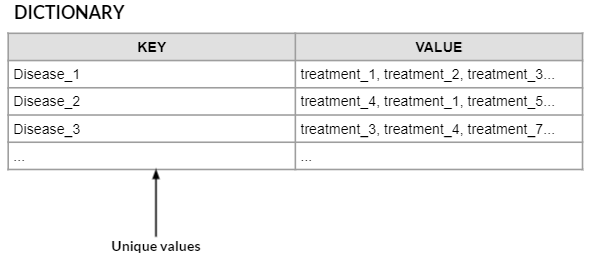

In [28]:
# Dictionary to store the diease name and treatements for the dieseas using predited lables of Y and test data
dieasesNdTreatments = dict();

for i in range(0, len(Y_pred)): # iterate through each sentence of Y_Pred labels
    predicted_tags = Y_pred[i]; # get the predicted labels for a sentence
    dieaseNames = "" # initialize the diesease names (Diesease name can have two words in it)
    treatments = ""; # Initialize the treatments 
    for j in range(0, len(predicted_tags)): # For each word in a predicted sentence check is it 'D' or 'T'
        predicted_tag = predicted_tags[j]; 
        if predicted_tag == "D": # Get dieases name if lable is 'D'
            dieaseNames += test_sent[i].split()[j] + " "; # get the diesease name using the position ('j') of that word from i-th sentence of test_sent data
        elif predicted_tag == "T": # Get treatment name if label is 'T'
            treatments += test_sent[i].split()[j] + " "; # get the treatment name using the position ('j') of that word from i-th sentence of test_sent data
            
    dieseaseName = dieaseNames.lstrip().rstrip(); # remove front and ending empty spaces
    treatment = treatments.lstrip().rstrip();
    
    # If the sentence is having any diease name and treatment in it then add it to dictionary
    if len(dieseaseName) != 0 and len(treatment) != 0:
        treatmentsList = dieasesNdTreatments.get(dieseaseName, []); # get treatements for a dieseas from dict if any. if not return empty list
        treatmentsList.append(treatment); # Add treatment into list
        dieasesNdTreatments[dieseaseName] = treatmentsList; # update treatmenmts list for a diesease in dictionary
    

In [29]:
dieasesNdTreatments # Print the whole dictionary

{'hereditary retinoblastoma': ['radiotherapy'],
 'unstable angina or non-Q-wave myocardial infarction': ['roxithromycin'],
 'coronary-artery disease': ['Antichlamydial antibiotics'],
 'primary pulmonary hypertension ( PPH )': ['fenfluramines'],
 'essential hypertension': ['moxonidine'],
 'foot infection': ['G-CSF treatment'],
 "early Parkinson 's disease": ['Ropinirole monotherapy'],
 'sore throat': ['Antibiotics'],
 "abdominal tuberculosis Crohn 's disease": ['steroids'],
 'female stress urinary incontinence': ['surgical treatment'],
 'stress urinary incontinence': ['therapy'],
 'preeclampsia ( proteinuric hypertension': ['intrauterine insemination with donor sperm versus intrauterine insemination'],
 'severe acquired hyperammonemia cancer': ['organ transplantation and chemotherapy'],
 'major pulmonary embolism': ['Thrombolytic treatment right-side hemodynamics'],
 'malignant pleural mesothelioma': ['thoracotomy , radiotherapy , and chemotherapy'],
 'pulmonary symptoms attributable': 

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [30]:
# Find the treatment for given diesease.
treatment_for_hereditaryRetinoblastoma = dieasesNdTreatments.get('hereditary retinoblastoma', []);
treatment_for_hereditaryRetinoblastoma

['radiotherapy']

### Tasks & Sub Tasks Acheived:
* Constructs proper sentences from individual words and prints five sentences
* Correctly counts the number of sentences in the processed train and test dataset
* Correctly counts the number of lines of labels in the processed train and test datasets
* Uses a toolkit like spaCy to extract those tokens that have NOUN or PROPN as their PoS tag and finds their frequency from the entire dataset that comprises both the train and the test datasets
* Prints the top 25 most common tokens with NOUN or PROPN PoS tags for the entire dataset that comprises both the train and the test datasets
* Defines the features with the PoS tag as one of the features
* While defining the features in which you have used the PoS tags, you also need to consider the preceding word of the current word. The use of the previous word’s information makes the CRF model more accurate and exhaustive
* Marks the beginning and end words of a sentence correctly in the form of features
* Writes the code to compute the features' value of a sentence
* Writes the code to get a list of labels of a given preprocessed label line that you have created earlier
* Extracts the features' values for each sentence as an input variable for the CRF model in the test and the train datasets
* Extracts the labels as the target variable for the test and the train datasets
* Builds the CRF model for a custom NER application
* Predicts the labels of each of the tokens in each sentence of the test dataset that has been preprocessed earlier
* Calculates the f1 score using the actual and the predicted labels of the test dataset
* Creates the code or logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset
* Predicts the treatment for the disease named 'hereditary retinoblastoma'